# Bottleneck nonlinear network for lower dimensional presentations of multimodal datasets

In [1]:
# Import packages
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib
import seaborn as sns
import sparseRRR
import matplotlib
import matplotlib.pyplot as plt
import importlib

import bottleneck_networks

import time
import pickle
import warnings

dtype = tf.float32

def sns_styleset():
    sns.set_style('ticks', {'axes.linewidth': .75, "xtick.major.size":4, "ytick.major.size":4})

# Loading data

For pre-processing (gene selection, delete ephys-rna mismatches, delete low rna quality cells, ...) of the raw data check BottleneckNN_preprocessing.

In [2]:
M1_ephys = pd.read_csv('M1Data/ephys_values.csv', index_col=0)
rpkm = pd.read_csv('M1Data/gene_counts.csv', index_col='gene')
geneNames = np.array(list(rpkm.index))

In [3]:
# Now specify for all the cells left what the cell type is (according to transcriptomic mappings)
prop = pd.read_csv('M1Data/mini-atlas-meta-data.csv', sep = '\t')
prop = prop.rename(columns = {'Sample': 'sample_id', 'Targeted layer': 'Layer'})
prop = prop[['Cell', 'RNA type', 'sample_id', 'Layer', 'Cre', 'RNA type top-3']]
#sample_name = ['{}{}{}'.format(g.split(' ')[0], 'sample', g.split(' ')[-1]) \
#               for g in (prop['Cell'].map(str.strip) + prop['sample_id'].map(str.strip)).tolist()]
sample_name = ['{}{}{}'.format(g.split('_')[0], g.split('_')[1], g.split('_')[2]) for g in prop['Cell']]
prop['sample name'] = sample_name
prop = prop.set_index('sample name')

prop = prop.reindex(M1_ephys.index) # There could be more cells with ephys than manually labelled
                                    # They will receive the Nan property
prop = prop.fillna('')
#M1_Allen_Mapping = np.array([g.split(',')[0].split('(')[0][:-1] if ',' in g else g.split('(')[0][:-1] \
#                             for g in prop['RNA type top-3']])
M1_Allen_Mapping = prop['RNA type']
M1_Allen_Mapping[np.where(M1_Allen_Mapping == '')[0]] = 'low quality'
number_labels = {c: i for i, c in enumerate(np.unique(M1_Allen_Mapping))}
cellTypes = np.array([number_labels[cell_type] for cell_type in M1_Allen_Mapping])

In [4]:
print('Double check:\n')
print('RPKM shape: ', rpkm.shape)
print('ephys shape: ', M1_ephys.shape)
print('cellTypes shape: ', cellTypes.shape)

Double check:

RPKM shape:  (1000, 1213)
ephys shape:  (1213, 16)
cellTypes shape:  (1213,)


In [5]:
cellTypeColors = {'Lamp5 Pax6': '#DDACC9', 'Lamp5 Egln3_1': '#FF88AD', 'Lamp5 Egln3_2': '#DD8091', 'Lamp5 Egln3_3': '#F08E98',
 'Lamp5 Pdlim5_1': '#FF7290', 'Lamp5 Pdlim5_2': '#FF8C97', 'Lamp5 Slc35d3': '#FFA388', 'Lamp5 Lhx6': '#C77963',
 'Sncg Col14a1': '#7E0ACB', 'Sncg Slc17a8': '#9440F3', 'Sncg Calb1_1': '#9611B6', 'Sncg Calb1_2': '#9900B3',
 'Sncg Npy2r': '#7A0099', 'Vip Sncg': '#AA4DB5', 'Vip Serpinf1_1': '#A720FF', 'Vip Serpinf1_2': '#AB1DFF',
 'Vip Serpinf1_3': '#FF5FCD', 'Vip Htr1f': '#FF4DC1', 'Vip Gpc3': '#B09FFF', 'Vip C1ql1': '#BD3D9A',
 'Vip Mybpc1_1': '#F70CF3', 'Vip Mybpc1_2': '#992E81', 'Vip Mybpc1_3': '#AB379C', 'Vip Chat_1': '#FF00FF',
 'Vip Chat_2': '#B3128A', 'Vip Igfbp6_1': '#7779BF', 'Vip Igfbp6_2': '#626EB8', 'Sst Chodl': '#FFFF00',
 'Sst Penk': '#FF8011', 'Sst Myh8_1': '#FF9F2C', 'Sst Myh8_2': '#FFB307', 'Sst Myh8_3': '#FFBF09',
 'Sst Htr1a': '#BFAF00', 'Sst Etv1': '#FFB22B', 'Sst Pvalb Etv1': '#D9C566', 'Sst Crhr2_1': '#BE8652',
 'Sst Crhr2_2': '#B0993C', 'Sst Hpse': '#CDB115', 'Sst Calb2': '#D2A328', 'Sst Pvalb Calb2': '#784F14',
 'Sst Pappa': '#635821', 'Sst C1ql3_1': '#802600', 'Sst C1ql3_2': '#8A2B1A', 'Sst Tac2': '#804600',
 'Sst Th_1': '#8C6012', 'Sst Th_2': '#A81111', 'Sst Th_3': '#9B211B', 'Pvalb Gabrg1': '#ED4C50',
 'Pvalb Egfem1': '#C05661', 'Pvalb Gpr149': '#E62A5D', 'Pvalb Kank4': '#BC4B11', 'Pvalb Calb1_1': '#B6411E',
 'Pvalb Calb1_2': '#BC2D71', 'Pvalb Reln': '#9C4165', 'Pvalb Il1rapl2': '#BC2C41', 'Pvalb Vipr2_1': '#FF197F',
 'Pvalb Vipr2_2': '#F4358B', 'L2/3 IT_1': '#00FF34', 'L2/3 IT_2': '#07D945', 'L2/3 IT_3': '#2EB934',
 'L4/5 IT_1': '#09CCC6', 'L4/5 IT_2': '#52B8AA', 'L5 IT_1': '#58D2C1', 'L5 IT_2': '#4A9F93', 'L5 IT_3': '#4EAC9C',
 'L5 IT_4': '#52B4B8', 'L6 IT_1': '#B2AD23', 'L6 IT_2': '#81791F', 'L6 IT Car3': '#5100FF', 'L5 PT_1': '#0D5D7E',
 'L5 PT_2': '#0B77A5', 'L5 PT_3': '#0B8AA5', 'L5 PT_4': '#0A75B1', 'L5/6 NP_1': '#48CB80', 'L5/6 NP_2': '#3C78BC',
 'L5/6 NP_3': '#47867A', 'L5/6 NP CT': '#1AAB99', 'L6 CT Gpr139': '#168577', 'L6 CT Cpa6': '#338C5E', 'L6 CT Grp': '#2FBCE5',
 'L6 CT Pou3f2': '#3E766C', 'L6 CT Kit_1': '#516B78', 'L6 CT Kit_2': '#557361', 'L6b Col6a1': '#69419D',
 'L6b Shisa6_1': '#46306A', 'L6b Shisa6_2': '#464576', 'L6b Ror1': '#7044AA', 'L6b Kcnip1': '#573D90'}

# Normalization of data

In [6]:
# Preprocess subset of the data in a systematic manner (library normalization and Z-scoring)
geneNames = np.array(list(rpkm.index))
Y = M1_ephys.values
X = rpkm.values.astype(np.float).T
X = X / np.sum(X, axis=1, keepdims=True) * \
                np.median(np.sum(X, axis=1, keepdims=True))

# Log-transform
X = np.log2(X + 1)

# Sort out cells with nans in the transcriptomic data
ind_non_nan = ~np.isnan(np.sum(X, axis=1))
X = X[ind_non_nan, :]
Y = Y[ind_non_nan, :]
cellTypes = cellTypes[ind_non_nan]

# Standardize Y
mu = np.mean(Y, axis=0)
Y = Y - mu
sigma = np.std(Y, axis=0)
Y = Y / sigma

# Standardize X
mu = np.mean(X, axis=0)
X = X - mu
sigma = np.std(X, axis=0)
X = X / sigma

X_no_low_qual = X.astype('float32')
Y_no_low_qual = Y.astype('float32')

In [7]:
cellTypeLabels = {i: c for i, c in enumerate(np.unique(M1_Allen_Mapping))}
amount_of_cells = {cell_type: sum(M1_Allen_Mapping==cell_type) for cell_type in np.unique(M1_Allen_Mapping)}
for_every_cell_number_of_cells_of_their_celltype = np.array([amount_of_cells[cellTypeLabels[c]] for c in cellTypes])
ind_pre_training = for_every_cell_number_of_cells_of_their_celltype >= 10

Let us find K-mean clusters to perform pre-training. One could also pre-train on celltype classification. This has actually improved performance even more but could be argued to be biasing the results too much. K-means allows for an unsupervised more general setting.

In [8]:
# You can cluster according to amounts of classes or amounts of celltypes. Change the argument of n_clusters accordingly.
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20, random_state=17, n_init=1000).fit(Y_no_low_qual)

In [9]:
clusters = kmeans.labels_

In [10]:
amount_of_cells_in_clusters = {cluster_id: sum(clusters==cluster_id) for cluster_id in np.unique(clusters)}
for_every_cell_number_of_cells_of_their_cluster = np.array([amount_of_cells_in_clusters[cell] for cell in clusters])
ind_pre_training_clusters = for_every_cell_number_of_cells_of_their_cluster >= 10

In [11]:
# So that we have other colours too that distinguish well among each other (for the clusters)
clusterCols = ["#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
       "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
       "#5A0007", "#809693", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
       "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
       "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
       "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
       "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
       "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
       "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
       "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
       "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
       "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
       "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",
       "#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800",
       "#BF5650", "#E83000", "#66796D", "#DA007C", "#FF1A59", "#8ADBB4", "#1E0200", "#5B4E51",
       "#C895C5", "#320033", "#FF6832", "#66E1D3", "#CFCDAC", "#D0AC94", "#7ED379", "#012C58"]

# Keras initialisations

In [12]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

In [14]:
def r2_score(y_truth, y_pred):
    residual = tf.add(y_truth, -y_pred, name='residual')
    return 1-tf.reduce_sum(tf.square(residual)) / tf.reduce_sum(tf.square(y_truth))

In [15]:
class ElasticNet(tf.keras.regularizers.Regularizer): 
    def __init__(self, l1=1e-8, l2=1.0): 
        self.l1 = l1
        self.l2 = l2

    def __call__(self, x): 
        return self.l2*tf.math.reduce_sum(tf.math.square(x)) + \
                             self.l1*tf.reduce_sum(tf.norm(x, ord = 2, axis = 1))

    def get_config(self): 
        return {'l1': float(self.l1), 'l2': float(self.l2)}

# Latent space visualization of favourite models

First we train the lasso 1e-1 freeze (4 last layers) unfreeze model for the entire dataset.

In [17]:
from bottleneck_networks import ClassificationPreTrain

In [18]:
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

act = 'elu'
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs


t = time.time()
np.random.seed(seed)
n = X_no_low_qual.shape[0]
X = np.copy(X_no_low_qual)
Y = np.copy(Y_no_low_qual)
clusters_ = np.copy(clusters)

CE_loss = np.zeros((l1_params.shape[0], l2_params.shape[0]))
CE_loss_tr = np.zeros((l1_params.shape[0], l2_params.shape[0]))
pre_tr_hist = np.zeros((l1_params.shape[0], l2_params.shape[0], epochs))
pre_tr_hist_tr = np.zeros((l1_params.shape[0], l2_params.shape[0], epochs))


pre_train_size = 0.6
train_cnt = round(X.shape[0]*pre_train_size)
x_train_pre_tr_ = X[:train_cnt, :]
x_test_pre_tr_ = X[train_cnt:, :]
clusters_train_pre_tr_ = clusters_[:train_cnt]
clusters_test_pre_tr_ = clusters_[train_cnt:]

for i, l2 in enumerate(l2_params):
    #print('Ridge penalty: ', l2)
    for j, l1 in enumerate(l1_params):
        #print('Lasso penalty: ', l1)


        input_dim = x_train_pre_tr_.shape[1]
        output_dim = to_categorical(clusters_train_pre_tr_).shape[1]
        BN_Classification = ClassificationPreTrain(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, \
                                                   output_dim=output_dim)
        # random cvfold_id number to make sure we don't mess with our cv results and that this is for the full dataset
        CE_train, CE_test, train_hist, test_hist = BN_Classification.train(x_train=x_train_pre_tr_, \
                                                                           cluster_train=clusters_train_pre_tr_, \
                                                                           x_test=x_test_pre_tr_, \
                                                                           cluster_test=clusters_test_pre_tr_, \
                                                                           epochs=epochs, bs=bs, patience=patience, \
                                                                           cvfold_id=1000, l1_id=j, l2_id=i, \
                                                                           verbose=0)
        CE_loss[j, i] = CE_test
        CE_loss_tr[j, i] = CE_train
        pre_tr_hist[j, i] = test_hist
        pre_tr_hist_tr[j, i] = train_hist
        #print('Test CE loss (pre-training): ', CE_loss[j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

Instructions for updating:
Colocations handled automatically by placer.
[INFO] training network...
Instructions for updating:
Use tf.cast instead.
485/485 [==============================] - 0s 82us/sample - loss: 2.7206 - categorical_crossentropy: 2.6383
[INFO] training network...
485/485 [==============================] - 0s 91us/sample - loss: 9.6669 - categorical_crossentropy: 2.4237
[INFO] training network...
485/485 [==============================] - 0s 76us/sample - loss: 60.4802 - categorical_crossentropy: 2.4315
[INFO] training network...
485/485 [==============================] - 0s 93us/sample - loss: 118.9184 - categorical_crossentropy: 2.1066
Time: 0.0h  1m 10s


In [22]:
importlib.reload(bottleneck_networks)

<module 'bottleneck_networks' from '/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/M1/Analysis/bottleneck_networks.py'>

In [16]:
from bottleneck_networks import FreezeUnfreeze

In [17]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

act = 'elu'
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
unfreeze = [False, False, True, True, True, True] # last 4 layers can be trained only first
prune=True

r2_freeze_unfreeze_hist_tr = np.zeros((l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = X_no_low_qual.shape[0]
X = np.copy(X_no_low_qual)
Y = np.copy(Y_no_low_qual)

    
input_dim = X.shape[1]
output_dim = Y.shape[1]


for i, l2 in enumerate(l2_params):
    #print('Ridge penalty: ', l2)
    for j, l1 in enumerate(l1_params):
        #print('Lasso penalty: ', l1)

        pre_trained_weights_h5 = 'KerasSavedModels/Classification_weights_{}_{}_{}.h5'.format(1000, j, i)
        input_dim = X.shape[1]
        output_dim = Y.shape[1]
        BN_PreTrFreezeUnfreeze = FreezeUnfreeze(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, output_dim=output_dim, \
                                                   unfreeze = unfreeze, \
                                                   pre_trained_weights=pre_trained_weights, \
                                                   pre_trained_weights_h5=pre_trained_weights_h5)
        # random cvfold_id number to make sure we don't mess with our cv results and that this is for the full dataset
        train_hist = BN_PreTrFreezeUnfreeze.train_full_dataset(x_train=X, y_train=Y, \
                                                                epochs=epochs, bs=bs, patience=patience, \
                                                                cvfold_id=2000, l1_id=j, l2_id=i, \
                                                                prune=prune, geneNames=geneNames, \
                                                                verbose=0)
        r2_freeze_unfreeze_hist_tr[j, i] = train_hist
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
[INFO] training network...
Instructions for updating:
Use tf.cast instead.
[INFO] training network...
The 25 genes that make it:  ['Zfp871' 'Ccser2' 'Thsd7a' 'Itih3' 'Slc6a1' 'Pvalb' 'Baiap3' 'Zfp551'
 'Kit' 'Ighm' 'Slc38a1' 'Lypd6b' 'Golm1' 'Klf6' 'Cdh13' 'Hnrnph1' 'Ntm'
 'Nfib' 'A330023F24Rik' 'Calb1' 'Selenop' 'Tac2' 'Cmtr2' 'Gm43670' 'C3ar1']
[INFO] training network...
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Gm49948' 'Bdnf' 'Ptprk' 'Kcnip1' 'Ndnf' 'Chrnb3' 'Tekt5' 'Tafa1'
 'Rasgrp1' 'Fxyd6' 'Pvalb' 'Galnt14' 'Gm11549' 'Tac2' 'Rph3a' 'Dlx6os1'
 'Crh' 'Slc6a1' 'Mas1' 'Adcyap1' 'Npy' 'Htr3a' 'Adarb2' 'Vip' 'Gad1']
[INFO] training network...
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Phactr1' 'Satb1' 'Olfm3' 'Enpp2' 'Slc6a1' 'Kcnip2' 'Dusp14' 'Gabrd'
 'Cacna1e' 'Unc13c' 'Nrip3' 'Atp1a

In [18]:
r2_freeze_unfreeze_hist_tr_Full_Dataset = r2_freeze_unfreeze_hist_tr

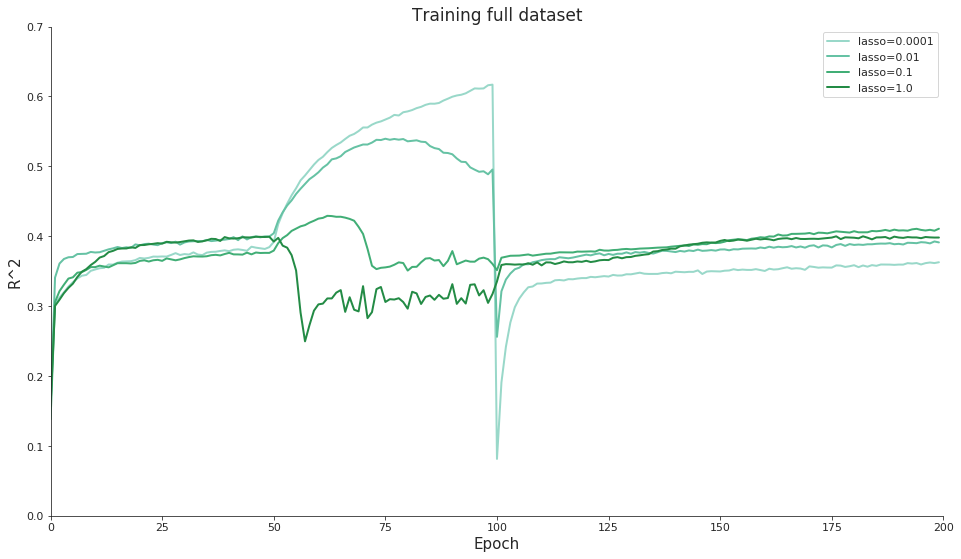

In [20]:
# The learning curves for our favourite model: pre-tr + train last 4 layers only + train all + prune
linewidth = 2
sns_styleset()

epochs_used = 200
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(111)

colours = ['#99d8c9', '#66c2a4', '#41ae76', '#238b45', '#005824']
for j, l1 in enumerate(l1_params):
    ax.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr_Full_Dataset, axis = (1))[j,:], \
             c = colours[j], linewidth=linewidth, label='lasso={}'.format(l1))
ax.set_ylim([0, 0.7])
ax.set_xlim([0, 200])
ax.set_title('Training full dataset', fontsize = 17)
ax.set_xlabel('Epoch', fontsize = 15)
ax.set_ylabel('R^2', fontsize = 15)
ax.legend(loc='best', fontsize = 11)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.tick_params(axis='both', which='minor', labelsize=11)
sns.despine()

#plt.savefig('Bottleneck_Learning_Curves_LASSO_Full_Dataset.png', dpi=200)

Let us pick our lasso parameter and see the average over cvfolds 25 biggest L2 norms of the first kernel and so on.

In [67]:
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

In [64]:
weights_before_unfreezing = []
for j, l1 in enumerate(l1_params):
    saved_model = load_model('KerasSavedModels/FreezeUnfreeze_before_unfreezing_full_dataset_{}_{}_{}.h5'.\
                             format(1000, j, 0), \
                             custom_objects={'r2_score': r2_score, 'ElasticNet': ElasticNet})
    weights_before_unfreezing.append(saved_model.get_weights()[0])
weights_before_unfreezing = np.array(weights_before_unfreezing)

In [68]:
weights_after_unfreezing = []
for j, l1 in enumerate(l1_params):
    saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_full_dataset_{}_{}_{}.h5'.\
                             format(1000, j, 0), \
                             custom_objects={'r2_score': r2_score, 'ElasticNet': ElasticNet})
    weights_after_unfreezing.append(saved_model.get_weights()[0])
weights_after_unfreezing = np.array(weights_after_unfreezing)

In [235]:
weights_after_unfreezing_ap = []
for j, l1 in enumerate(l1_params):
    saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                             format(1000, j, 0), \
                             custom_objects={'r2_score': r2_score, 'ElasticNet': ElasticNet})
    weights_after_unfreezing_ap.append(saved_model.get_weights()[0])
weights_after_unfreezing_ap = np.array(weights_after_unfreezing_ap)

In [16]:
weights_after_unfreezing_bootstrapping = []
for f in range(10):
    saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_full_dataset_{}_{}_{}.h5'.\
                             format(2000+f, 0, 0), \
                             custom_objects={'r2_score': r2_score, 'ElasticNet': ElasticNet})
    weights_after_unfreezing_bootstrapping.append(saved_model.get_weights()[0])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [17]:
counter_0_list=[]
counter_1_list=[]
sRRRrank2genes = np.array(['Bdnf', 'Gad1', 'Lamp5', 'Plch2', 'Gabrd', 'Cacna2d1', 'Elfn1', 'Slc6a1', 'Nxph1', \
 'Tac1', 'Npas1', 'Ndn', 'Arpp21', 'Htr3a', 'Mybpc1', 'Tac2', 'Coro6', 'Nrn1',
 'Synpr', 'Ptk2b', 'Kcnv1', 'Pvalb', 'Sst', 'Galnt14', 'Kcnip2']) # See later on how this is constructed
for f in range(10):
    BNN_genes = geneNames[np.argsort(np.linalg.norm(weights_after_unfreezing_bootstrapping[f], \
                                                 ord=2, axis=1), axis = 0)][-25:]
    if f!=9:
        BNN_genes_next = geneNames[np.argsort(np.linalg.norm(weights_after_unfreezing_bootstrapping[f+1], \
                                                 ord=2, axis=1), axis = 0)][-25:]
    print('\nrun {}: \n'.format(f), BNN_genes)
    print('Found for sRRR rank 2 too: ')
    counter_0=0
    for gene in BNN_genes:
        if gene in sRRRrank2genes:
            print(gene)
            counter_0+=1
    counter_0_list.append(counter_0)
    print('Found in the next run too: ')
    counter_1=0
    for gene in BNN_genes:
        if f!=9:
            if gene in BNN_genes_next:
                print(gene)
                counter_1+=1
    if f!=9:
        counter_1_list.append(counter_1)    


run 0: 
 ['Nell1' 'Mas1' 'Enpp2' 'Gm11549' 'Gabra1' 'Erbb4' 'Ptk2b' 'Pcp4' 'Bdnf'
 'Grm7' 'Gas7' 'Elfn1' 'Cacna2d1' 'Slc6a1' 'Atp1a3' 'Satb1' 'Plch2'
 'Mybpc1' 'Tac2' 'Ndn' 'Htr3a' 'Sst' 'Lamp5' 'Gad1' 'Pvalb']
Found for sRRR rank 2 too: 
Ptk2b
Bdnf
Elfn1
Cacna2d1
Slc6a1
Plch2
Mybpc1
Tac2
Ndn
Htr3a
Sst
Lamp5
Gad1
Pvalb
Found in the next run too: 
Mas1
Enpp2
Gm11549
Gabra1
Pcp4
Grm7
Elfn1
Slc6a1
Atp1a3
Satb1
Plch2
Mybpc1
Tac2
Ndn
Htr3a
Sst
Lamp5
Gad1
Pvalb

run 1: 
 ['Mas1' 'Gabrd' 'Enpp2' 'Mybpc1' 'Gm11549' 'Dusp14' 'Cck' 'Satb1' 'Cplx1'
 'Gabra1' 'Grm7' 'Slc6a1' 'Atp1a3' 'Plch2' 'Kcnip2' 'Galnt14' 'Elfn1'
 'Pcp4' 'Ndn' 'Lamp5' 'Htr3a' 'Gad1' 'Tac2' 'Pvalb' 'Sst']
Found for sRRR rank 2 too: 
Gabrd
Mybpc1
Slc6a1
Plch2
Kcnip2
Galnt14
Elfn1
Ndn
Lamp5
Htr3a
Gad1
Tac2
Pvalb
Sst
Found in the next run too: 
Mybpc1
Satb1
Cplx1
Slc6a1
Atp1a3
Plch2
Lamp5
Gad1
Pvalb

run 2: 
 ['Usp14' 'Gas7' 'Ak5' 'Tac1' 'Ptgs2' 'Flt3' 'Slc6a1' 'Coro6' 'Cplx1'
 'Cacna2d3' 'Plch2' 'Satb1' 'Adcyap1' 'Atp1a3' 'Mybp

In [18]:
BNN_genes_list = []
for f in range(10):
    BNN_genes = geneNames[np.argsort(np.linalg.norm(weights_after_unfreezing_bootstrapping[f], \
                                                 ord=2, axis=1), axis = 0)][-25:]
    BNN_genes_list.append([BNN_genes])
BNN_genes_list = np.reshape(np.array(BNN_genes_list), newshape=25*10)
for gene in np.unique(BNN_genes_list):
    print(gene,  sum(BNN_genes_list==gene))

Adcyap1 1
Ak5 1
Atp1a3 10
Bdnf 3
Cacna2d1 5
Cacna2d3 2
Cck 4
Chat 1
Col24a1 1
Coro6 2
Cplx1 8
Dclk3 1
Dusp14 4
Elfn1 9
Enpp2 5
Erbb4 3
Flt3 1
Fxyd6 1
Gabra1 7
Gabrd 6
Gad1 10
Galnt14 6
Gas7 3
Gm11549 5
Grm7 9
Htr3a 9
Kcnc2 2
Kcnip2 8
Lamp5 10
Mas1 2
Mybpc1 5
Ndn 9
Ndst3 4
Nell1 2
Pcp4 9
Pcp4l1 1
Pde1a 3
Plch2 10
Ptgs2 1
Ptk2b 5
Pvalb 10
Reln 1
Satb1 10
Slc6a1 10
Sparcl1 3
Sst 9
Synpr 1
Tac1 5
Tac2 9
Usp14 1
Vip 3


In [19]:
np.mean(counter_0_list)

14.1

In [20]:
np.mean(counter_1_list)

17.666666666666668

In [33]:
# For our model
sRRRrank2genes = np.array(['Bdnf', 'Gad1', 'Lamp5', 'Plch2', 'Gabrd', 'Cacna2d1', 'Elfn1', 'Slc6a1', 'Nxph1', \
 'Tac1', 'Npas1', 'Ndn', 'Arpp21', 'Htr3a', 'Mybpc1', 'Tac2', 'Coro6', 'Nrn1',
 'Synpr', 'Ptk2b', 'Kcnv1', 'Pvalb', 'Sst', 'Galnt14', 'Kcnip2']) # See later on how this is constructed
BNN_genes = geneNames[np.argsort(np.linalg.norm(weights_after_unfreezing, \
                                             ord=2, axis=2), axis = 1)[2, :]][-25:]
counter_0=0
for gene in BNN_genes:
    if gene in sRRRrank2genes:
        print(gene)
        counter_0+=1

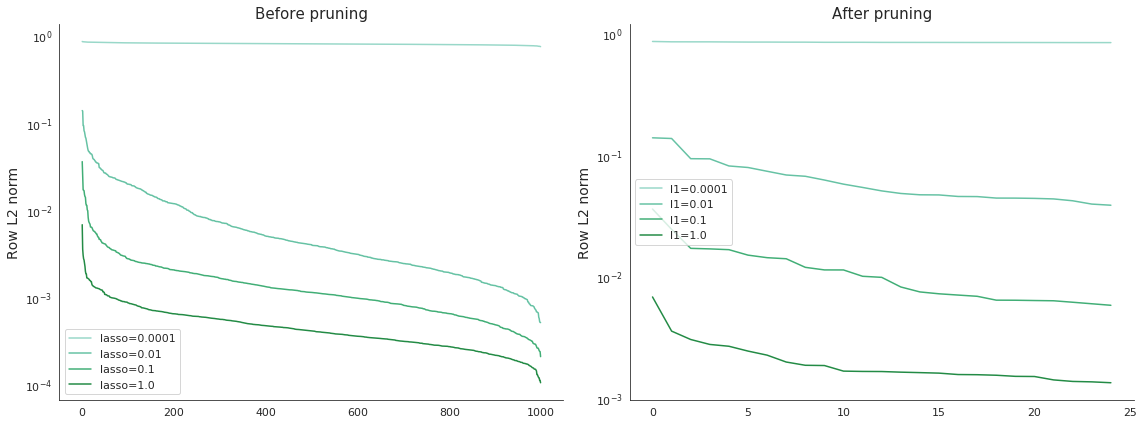

In [237]:
fig = plt.figure(figsize = (16, 6))
ax1 = fig.add_subplot(121)
colours = ['#99d8c9', '#66c2a4', '#41ae76', '#238b45', '#005824']
for j, l1 in enumerate(l1_params):
    ax1.plot(range(1000), np.sort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[j, ::-1].T, \
             c = colours[j], label = 'lasso={}'.format(l1))
ax1.set_ylabel('Row L2 norm', fontsize = 14)
ax1.set_title('Before pruning', fontsize = 15)
ax1.tick_params(axis='both', which='major', labelsize=11)
ax1.tick_params(axis='both', which='minor', labelsize=11)
ax1.set_yscale('log')
ax1.legend(loc='best', fontsize=11)

ax2 = fig.add_subplot(122)
for j, l1 in enumerate(l1_params):
    ax2.plot(range(25), np.sort(np.linalg.norm(weights_after_unfreezing_ap, ord=2, axis=2), axis = 1)[j, ::-1].T, \
             c = colours[j], label = 'l1={}'.format(l1))
ax2.set_ylabel('Row L2 norm', fontsize = 14)
ax2.set_title('After pruning', fontsize = 15)
ax2.tick_params(axis='both', which='major', labelsize=11)
ax2.tick_params(axis='both', which='minor', labelsize=11)
ax2.set_yscale('log')
ax2.legend(loc='best', fontsize=11)
sns.despine()

#fig.suptitle('Row L2 norm of the first kernel in the network before and after pruning', y = 1.05, fontsize=18)
plt.tight_layout()

plt.savefig('Bottleneck_lasso_pruning_L2_norms_FULL_DATASET.png', dpi=200)

In [59]:
lambdas = np.arange(.1,2,.1)

In [134]:
with open('KerasSavedModels/sRRR_vs_Bottleneck_rank2_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2 = pickle.load(f)

In [135]:
with open('KerasSavedModels/sRRR_vs_Bottleneck_rank16_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank16, r2_sRRR_relaxed_rank16, r2_sRRR_rank16_tr, r2_sRRR_relaxed_rank16_tr, \
                nonzero_rank16, corrs_rank16, corrs_relaxed_rank16 = pickle.load(f)

In [136]:
# This should be a pickled file created from the other notebook
with open('KerasSavedModels/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso.pickle', 'rb') as f:
        r2_before_unfreezing, r2_before_unfreezing_tr, \
        r2_after_unfreezing, r2_after_unfreezing_tr, \
        r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
        r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr = pickle.load(f)

In [137]:
r2_freeze_unfreeze_hist.shape

(10, 4, 1, 200)

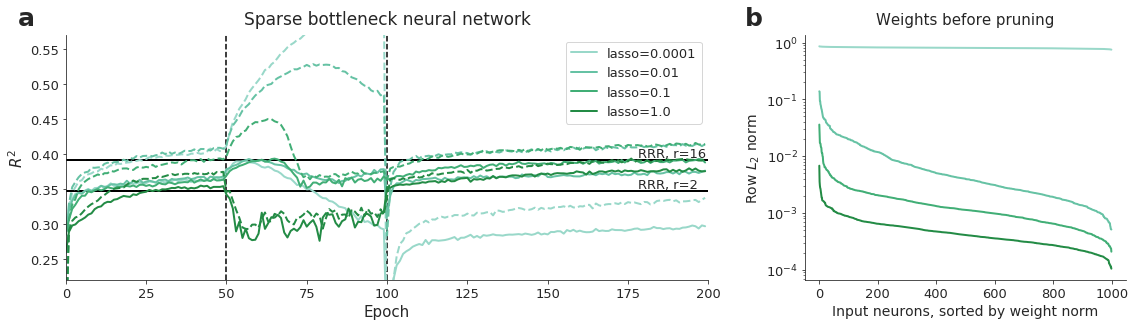

In [142]:
# Everything in one figure for the paper
linewidth = 2
sns_styleset()
epochs_used = 200
colours = ['#99d8c9', '#66c2a4', '#41ae76', '#238b45', '#005824']

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

fig = plt.figure(figsize=(19, 4.5))
widths = [2, 1]
heights = [1]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths,
                          height_ratios=heights)

ax1 = fig.add_subplot(spec[0, 0])
for j, l1 in enumerate(l1_params):
    ax1.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr, axis = (0, 2))[j, :].T, \
             '--', c = colours[j], linewidth=linewidth)
    ax1.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist, axis = (0, 2))[j, :].T, \
             c = colours[j], linewidth=linewidth, label='lasso={}'.format(l1))
ax1.hlines(r_rank16_r[np.isclose(n_rank16, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax1.hlines(r_rank2_r[np.isclose(n_rank2, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax1.annotate('RRR, r=16', (178, r_rank16_r[np.isclose(n_rank16, 25, atol=3)]+0.004), fontsize=13)
ax1.annotate('RRR, r=2', (178, r_rank2_r[np.isclose(n_rank2, 25, atol=3)]+0.004), fontsize=13)
ax1.set_ylim([0.22, 0.57])
ax1.set_xlim([0, epochs_used])
ax1.set_title('Sparse bottleneck neural network', fontsize = 17, y=1.02)
ax1.set_xlabel('Epoch', fontsize = 15)
ax1.set_ylabel(r'$R^2$', fontsize = 15)
ax1.legend(loc='best', fontsize = 13)
ax1.tick_params(axis='both', which='major', labelsize=13)
ax1.tick_params(axis='both', which='minor', labelsize=13)
ax1.set_xticks(np.arange(0, 225, 25))
ax1.vlines(x=50, ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], linestyles='dashed')
ax1.vlines(x=100, ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], linestyles='dashed')

ax2 = fig.add_subplot(spec[0, 1])
colours = ['#99d8c9', '#66c2a4', '#41ae76', '#238b45', '#005824']
for j, l1 in enumerate(l1_params):
    ax2.plot(range(1000), np.sort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[j, ::-1].T, \
             c = colours[j], label = 'lasso={}'.format(l1), linewidth=linewidth)
ax2.set_ylabel(r'Row $L_2$ norm', fontsize = 14)
ax2.set_xlabel('Input neurons, sorted by weight norm', fontsize = 14)
ax2.set_title('Weights before pruning', fontsize = 15, y=1.02)
ax2.tick_params(axis='both', which='major', labelsize=13)
ax2.tick_params(axis='both', which='minor', labelsize=13)
ax2.set_yscale('log')

plt.text(-0.075, 1.04, 'a', transform = ax1.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.185, 1.04, 'b', transform = ax2.transAxes, fontsize=25, fontweight='bold')
sns.despine()

#plt.savefig('Bottleneck_Figure4.png', bbox_inches = 'tight',
#    pad_inches = 0)
plt.savefig('Bottleneck_Figure4.pdf', bbox_inches = 'tight',
    pad_inches = 0)

In [139]:
# Print the genes selected for this lasso, our favourite model 
highest_genes = 25
for j, l1 in enumerate(l1_params):
    print('For lasso: {}'.format(l1), \
          '\nThese {} highest genes were selected: '.format(highest_genes), \
         geneNames[np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[j, ::-1][:highest_genes]])

For lasso: 0.0001 
These 25 highest genes were selected:  ['Osbpl1a' 'Mapk8ip3' 'Strap' 'Sst' 'Magee2' 'Naa60' 'Mmgt1' 'Rab18'
 'St3gal5' 'Coro6' 'Gpr176' 'Aars' 'Adcyap1' 'Pvalb' 'Crispld2' 'Ogt'
 'Zfp871' '2900011O08Rik' 'Egr1' 'Ctsb' 'Zcchc12' 'Peg3' 'Thbs2' 'Pde1a'
 'Trf']
For lasso: 0.01 
These 25 highest genes were selected:  ['Vip' 'Sst' 'Pvalb' 'Coro6' 'Tac2' 'Lamp5' 'Gad1' 'Ndn' 'Thsd7a'
 'Dlx6os1' 'Adarb2' 'Cplx1' 'Mas1' 'Vstm2a' 'Synpr' 'Ndst3' 'Pcdhb10'
 'Htr3a' 'Rph3a' 'Pcp4l1' 'Slc6a1' 'Flt3' 'Prox1' 'Ptk2b' 'Arpp19']
For lasso: 0.1 
These 25 highest genes were selected:  ['Sst' 'Pvalb' 'Ndst3' 'Gad1' 'Coro6' 'Lamp5' 'Tac2' 'Synpr' 'Htr3a' 'Ndn'
 'Cbln2' 'Vip' 'Cplx1' 'Mas1' 'Grm7' 'Thsd7a' 'Atp1a3' 'Fezf2' 'Chat'
 'Bdnf' 'Ptpru' 'Gm11549' 'Ptgs2' 'Trp53i11' 'Flt3']
For lasso: 1.0 
These 25 highest genes were selected:  ['Pvalb' 'Gad1' 'Lamp5' 'Elfn1' 'Sst' 'Ndn' 'Tac2' 'Synpr' 'Cacna2d3'
 'Cacna2d1' 'Dclk3' 'Bdnf' 'AW551984' 'Asns' 'Mybpc1' 'Cyp1b1' 'Fam107b'
 'Pcp4l1' '

In [62]:
# And what are the genes selected for sRRR for the different cross validated sets and the lambdau we'd have to pick?

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

t = time.time()

np.random.seed(seed)
n = X_no_low_qual.shape[0]
X = np.copy(X_no_low_qual)
Y = np.copy(Y_no_low_qual)

X = X.astype('float64')
Y = Y.astype('float64')

vx_rank2, vy_rank2 = sparseRRR.elastic_rrr(X, Y, \
                            lambdau=lambdas[np.isclose(n_rank2, 25, atol=3)], alpha=1, rank=2, sparsity='row-wise')
print('For rank 2, ', \
      '\nThese highest genes were selected: ', \
      geneNames[np.sum(vx_rank2, axis = 1)!=0])
vx_rank16, vy_rank16 = sparseRRR.elastic_rrr(X, Y, \
                            lambdau=lambdas[np.isclose(n_rank16, 25, atol=3)], alpha=1, rank=16, sparsity='row-wise')

print('For rank 16, ', \
      '\nThese highest genes were selected: ', \
      geneNames[np.sum(vx_rank16, axis = 1)!=0])

For rank 2,  
These highest genes were selected:  ['Bdnf' 'Gad1' 'Lamp5' 'Plch2' 'Gabrd' 'Cacna2d1' 'Elfn1' 'Slc6a1' 'Tac1'
 'Npas1' 'Arpp21' 'Htr3a' 'Mybpc1' 'Coro6' 'Nrn1' 'Synpr' 'Ptk2b' 'Kcnv1'
 'Pvalb' 'Sst' 'Kcnip2']
For rank 16,  
These highest genes were selected:  ['Erbb4' 'Bdnf' 'Gad1' 'Lamp5' 'Bcan' 'Plch2' 'Gabrd' 'Cacna2d1' 'Elfn1'
 'Slc6a1' 'Tac1' 'Arpp21' 'Htr3a' 'Mybpc1' 'Vip' 'Coro6' 'Nrn1' 'Synpr'
 'Ptk2b' 'Pvalb' 'Sst' 'Kcnip2']


# Visualisation latent spaces

In [24]:
from tensorflow.keras import backend as K
from scipy.interpolate import SmoothBivariateSpline

Text(0.5, 1.0, 'Latent space')

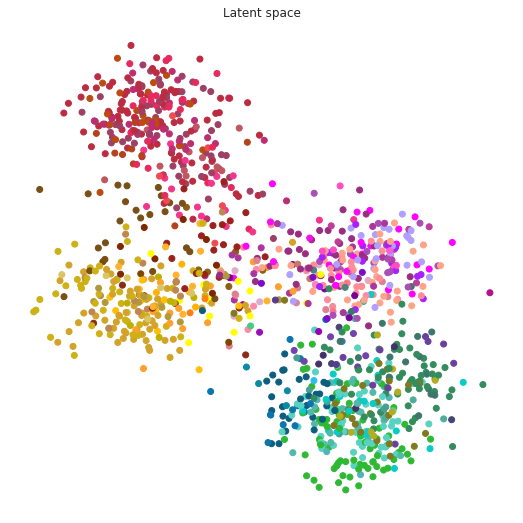

In [103]:
# Before unfreezing
lasso_id=2
saved_model = load_model('KerasSavedModels/FreezeUnfreeze_before_unfreezing_full_dataset_{}_{}_{}.h5'.\
                        format(1000, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
ephys_prediction_from_bottleneck = K.function([saved_model.get_layer('bottleneck').output],
                                  [saved_model.output])
#layer_output = ephys_prediction_from_bottleneck(np.array([0, 0])[np.newaxis, :])[0]
latent = encoder.predict(X_no_low_qual)                 # bottleneck representation

sns.set_style('white')
plt.figure(figsize = (9, 9))
plt.scatter(latent[:, 0], latent[:, 1],
            c = [cellTypeColors[cellTypeLabels[cell_type]] for cell_type in cellTypes_no_low_qual])
sns.despine(bottom = True, left = True)
plt.xticks([])
plt.yticks([])
plt.title('Latent space')

R^2 score on all:  0.4172211289405823


Text(0.5, 1.0, 'Latent space')

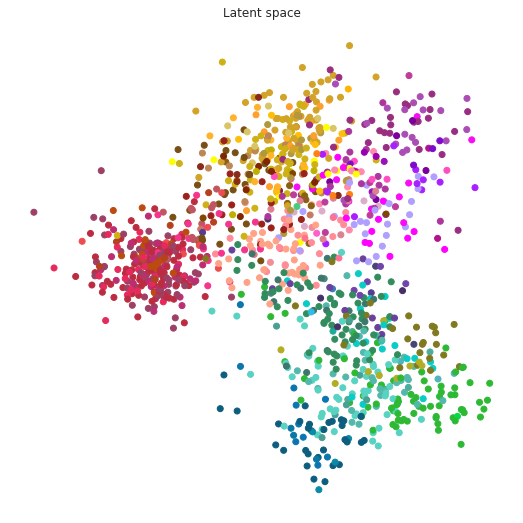

In [233]:
# After unfreezing
lasso_id=2
saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_full_dataset_{}_{}_{}.h5'.\
                        format(1000, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
ephys_prediction_from_bottleneck = K.function([saved_model.get_layer('bottleneck').output],
                                  [saved_model.output])
#layer_output = ephys_prediction_from_bottleneck(np.array([0, 0])[np.newaxis, :])[0]
latent = encoder.predict(X_no_low_qual)                 # bottleneck representation
ephys_prediction = saved_model.predict(X_no_low_qual)             # class prediction
print('R^2 score on all: ', 1-np.sum((Y_no_low_qual - saved_model.predict(x=X_no_low_qual))**2) / np.sum(Y_no_low_qual**2))

sns.set_style('white')
plt.figure(figsize = (9, 9))
plt.scatter(latent[:, 0], latent[:, 1],
            c = [cellTypeColors[cellTypeLabels[cell_type]] for cell_type in cellTypes_no_low_qual])
sns.despine(bottom = True, left = True)
plt.xticks([])
plt.yticks([])
plt.title('Latent space')

R^2 score on all:  0.29057103395462036


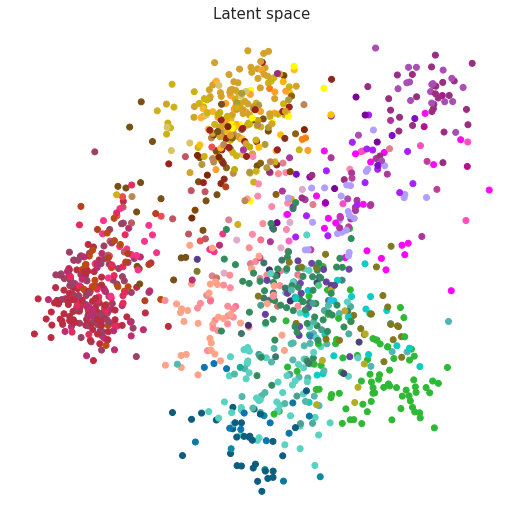

In [147]:
# Pick a NN L2 reg parameter number
lasso_id=2   # a number from 0 to 3 (corresponding to 1e-4, 1e-2, 1e-1, 1 lasso penalty respectively)



saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format(1000, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
ephys_prediction_from_bottleneck = K.function([saved_model.get_layer('bottleneck').output],
                                  [saved_model.output])
#layer_output = ephys_prediction_from_bottleneck(np.array([0, 0])[np.newaxis, :])[0]
ind_genes = np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[lasso_id, :][-25:]
latent = encoder.predict(X_no_low_qual[:, ind_genes])                 # bottleneck representation
ephys_prediction = saved_model.predict(X_no_low_qual[:, ind_genes])             # class prediction
print('R^2 score on all: ', 1-np.sum((Y_no_low_qual - \
                                      saved_model.predict(x=X_no_low_qual[:, ind_genes]))**2) / np.sum(Y_no_low_qual**2))

sns.set_style('white')
plt.figure(figsize = (9, 9))
plt.scatter(latent[:, 0], latent[:, 1],
            c = [cellTypeColors[cellTypeLabels[cell_type]] for cell_type in cellTypes_no_low_qual])
sns.despine(bottom = True, left = True)
plt.xticks([])
plt.yticks([])
plt.title('Latent space', fontsize=15)
plt.savefig('Bottleneck_latent.png', bbox_inches = 'tight',
    pad_inches = 0)

In [1]:
# sns.set_style('white')
# plt.figure(figsize = (9, 9))
# x = np.linspace(np.min(latent[:, 0]), np.max(latent[:, 0]), 40)
# y = np.linspace(np.min(latent[:, 1]), np.max(latent[:, 1]), 40)
# xv, yv = np.meshgrid(x, y)
# grid = np.empty((xv.shape[0], xv.shape[1]))

# for i in range(grid.shape[0]):
#     for j in range(grid.shape[1]):
#         #print(xv[i, j], yv[i, j])
#         grid[i, j] = ephys_prediction_from_bottleneck(np.array([xv[i, j], yv[i, j]])[np.newaxis, :])[0][0, 14]
# plt.contourf(x, y, grid, alpha = 1)
# plt.scatter(latent[:, 0], latent[:, 1],
#             c = ephys_prediction[:, 14])

# #plt.scatter(latent[:, 0], latent[:, 1],
# #            c = ephys_prediction_from_bottleneck(latent[:, 0], latent[:, 1])[:, 14])

# #colour = np.zeros_like((latent[:, 0]))
# #for i in range(latent.shape[0]):
# #    colour[i] = ephys_prediction_from_bottleneck(latent[i,:][np.newaxis, :])[0][0, 14]
# #plt.scatter(latent[:, 0], latent[:, 1],
# #            c = ephys_prediction_from_bottleneck(encoder.predict(X_no_low_qual[:, ind_genes]))[0][:, 14])

# #plt.scatter(latent[:, 0], latent[:, 1],
# #            c = colour)

# sns.despine(bottom = True, left = True)
# plt.xticks([])
# plt.yticks([])
# #plt.xlim([np.min(latent[:, 0]), np.max(latent[:, 0])])
# #plt.ylim([np.min(latent[:, 1]), np.max(latent[:, 1])])
# plt.title('Latent space')
# #plt.savefig('LatentSpace.png')

In [110]:
# sns.set_style('white')
# plt.figure(figsize = (9, 9))
# x = np.linspace(np.min(latent[:, 0]), np.max(latent[:, 0]), 40)
# y = np.linspace(np.min(latent[:, 1]), np.max(latent[:, 1]), 40)
# xv, yv = np.meshgrid(x, y)
# grid = np.empty((xv.shape[0], xv.shape[1]))

# for i in range(grid.shape[0]):
#     for j in range(grid.shape[1]):
#         #print(xv[i, j], yv[i, j])
#         grid[i, j] = ephys_prediction_from_bottleneck(np.array([xv[i, j], yv[i, j]])[np.newaxis, :])[0][0, 14]
# plt.contourf(x, y, grid, alpha = 1)
# plt.scatter(xv, yv, c = grid)
# sns.despine(bottom = True, left = True)
# plt.xticks([])
# plt.yticks([])
# #plt.xlim([np.min(latent[:, 0]), np.max(latent[:, 0])])
# #plt.ylim([np.min(latent[:, 1]), np.max(latent[:, 1])])
# plt.title('Latent space')
# plt.savefig('LatentSpace.png')

In [111]:
# sns_styleset()
# plt.figure(figsize = (9, 9))
# plt.tricontourf(latent[:, 0], latent[:, 1], ephys_prediction_from_bottleneck(latent)[0][:, 14])
# #plt.scatter(latent[:, 0], latent[:, 1],
# #            c = ephys_prediction[:, 14])

# plt.scatter(latent[:, 0], latent[:, 1],
#             c = ephys_prediction_from_bottleneck(latent)[0][:, 14])
# sns.despine(bottom = True, left = True)
# plt.xticks([])
# plt.yticks([])
# #plt.xlim([np.min(latent[:, 0]), np.max(latent[:, 0])])
# #plt.ylim([np.min(latent[:, 1]), np.max(latent[:, 1])])
# plt.title('Latent space')
# plt.savefig('LatentSpace.png')

In [112]:
# sns.set_style('white')
# plt.figure(figsize = (9, 9))
# saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.format(1000, 1, 0), \
#                         custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# # Retrieve activations and ephys prediction
# encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
# ind_genes = np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[1, :][-25:]
# latent = encoder.predict(X_no_low_qual[:, ind_genes])                 # bottleneck representation

# f = SmoothBivariateSpline(latent[:, 0], latent[:, 1], X_no_low_qual[:, ind_genes][:, -3])
# plt.tricontourf(latent[:,0], latent[:,1], f.ev(latent[:, 0], latent[:,1]))
# plt.scatter(latent[:,0], latent[:,1],
#             c = X_no_low_qual[:, ind_genes][:, -3])
# sns.despine(bottom = True, left = True)
# plt.xticks([])
# plt.yticks([])
# #plt.xlim([np.min(latent[:, 0]), np.max(latent[:, 0])])
# #plt.ylim([np.min(latent[:, 1]), np.max(latent[:, 1])])
# plt.title('Latent space')
# plt.savefig('LatentSpace.png')

In [113]:
# sns.set_style('white')
# plt.figure(figsize = (9, 9))
# plt.scatter(latent[:, 0], latent[:, 1],
#             c = Y_no_low_qual[:, 14], s=20)
# sns.despine(bottom = True, left = True)
# plt.xticks([])
# plt.yticks([])
# #plt.xlim([np.min(latent[:, 0]), np.max(latent[:, 0])])
# #plt.ylim([np.min(latent[:, 1]), np.max(latent[:, 1])])
# plt.title('Latent space')
# #plt.savefig('LatentSpace.png')

In [114]:
# def contour(model, X, Y, Y_column_index, features, celltypes, cellTypeLabels, cellTypeColors, alpha = 0.5, axes = None):
#     ''' Returns a first latent space of the neural network defined by the keras model coloured by celltype. Returns a
#     second latent space with predicted ephys feature contours and data points coloured by this predicted ephys feature.
#     A third latent space is also provided with the same contours
#     but this time data points are coloured by truth ephys feature values. The ephys feature corresponds to a callableolumn in
#     Y provided by Y_column_index.
    
#     Parameters
#     ---------
#     model: keras deep bottleneck neural network regression model
#     X: 2D numpy array, normalized transcriptomic data
#     Y: 2D numpy array, normalized ephys data
#     Y_column_index: column index in Y, correspoding to certain feature
#     features: list of all ephys features (Y_column_index should correspond to correct feature in this list!)
#     celltypes: 1D numpy array, same size as first dimension of X and Y, numbers denote celltype/cellclass
#     celltypeLabels: dictionary with celltype numbers corresponding to celltype names
#     celltypeColors: dictionary with celltype names corresponding to celltype colours
#     alpha: transparancy for contours (default = 0.5)
#     axes: axes to plot one (default: None)
    
#     Returns
#     ---------
#     axes: figure objects; two subplots corresponding to predicted and truth colour coding of data points with
#           same predicted contours
#     '''
#     # Create mappings from the model to get latent activations from genes and ephys predictions from genes and
#     # latent activations
#     encoder = Model(model.input, model.get_layer('bottleneck').output)
#     latent = encoder.predict(X)                           # bottleneck representation
#     ephys_prediction = saved_model.predict(X)             # class prediction
#     ephys_prediction_from_bottleneck = K.function([saved_model.get_layer('bottleneck').output], [saved_model.output])
    
#     # Create a grid in the latent space. For every coordinate/every latent space activation sequence, check its predicted
#     # ephys feature
#     x = np.linspace(np.min(latent[:, 0]), np.max(latent[:, 0]), 20)
#     y = np.linspace(np.min(latent[:, 1]), np.max(latent[:, 1]), 20)
#     xv, yv = np.meshgrid(x, y)
#     grid = np.empty((xv.shape[0], xv.shape[1]))
#     for i in range(grid.shape[0]):
#         for j in range(grid.shape[1]):
#             grid[i, j] = ephys_prediction_from_bottleneck(np.array([xv[i, j], yv[i, j]])[np.newaxis, :])[0][0, Y_column_index]
    
#     # Create figure
#     if axes:
#         axes = axes
#     else:
#         fig, axes = plt.subplots(nrows=1,ncols=3, figsize = (16, 6))
#     axes[0].scatter(latent[:, 0], latent[:, 1], c = [cellTypeColors[cellTypeLabels[cell_type]] for cell_type in celltypes])
#     axes[1].contourf(x,y,grid, alpha=alpha)
#     axes[1].scatter(latent[:, 0], latent[:, 1], c = ephys_prediction[:, Y_column_index])
#     axes[2].contourf(x,y,grid, alpha=alpha)
#     axes[2].scatter(latent[:, 0], latent[:, 1], c = Y_no_low_qual[:, Y_column_index])
#                     #c = X[:, 6])

#     for ax in axes:
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.set_xticklabels('')
#         ax.set_yticklabels('')
#     sns.despine(bottom=True, left=True)
#     fig.suptitle(features[Y_column_index], fontsize = 20)
#     plt.tight_layout()
#     return axes

In [115]:
# saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.format(1000, 1, 0), \
#                         custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})
# ind_genes = np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[1, :][-25:]
# for i in range(Y_no_low_qual.shape[1]):
#     #fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (16, 6))
#     contour(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
#             i, M1_ephys.columns, cellTypes_no_low_qual, cellTypeLabels, \
#             cellTypeColors)
#     plt.savefig('LatentSpaceContours/LatentSpaceContoursFor_{}'.format(M1_ephys.columns[i]), dpi=200)

In [116]:
# for i, feature in enumerate(list(M1_ephys.columns)):
#     plt.figure()
#     plt.scatter(Y_no_low_qual[:, i], ephys_prediction[:, i])
#     plt.xlabel('True')
#     plt.ylabel('Predicted')
#     plt.title(feature)
#     plt.savefig('Correlations/{}'.format(feature))

In [96]:
def latent_space_ephys(model, X, Y, Y_column_index, features, celltypes, cellTypeLabels, \
                       cellTypeColors, alpha = 1, axis = None):
    '''
    Parameters
    ----------
    model: keras deep bottleneck neural network regression model
    X: 2D numpy array, normalized transcriptomic data
    Y: 2D numpy array, normalized ephys data
    Y_column_index: column index in Y, correspoding to certain feature
    features: list of all ephys features (Y_column_index should correspond to correct feature in this list!)
    celltypes: 1D numpy array, same size as first dimension of X and Y, numbers denote celltype/cellclass
    celltypeLabels: dictionary with celltype numbers corresponding to celltype names
    celltypeColors: dictionary with celltype names corresponding to celltype colours
    alpha: transparancy for contours (default = 0.5)
    axis: axis to plot one (default: None)
    
    Returns
    -------
    ax: figure objects; latent space with gene activation contours
    '''
    # Create mappings from the model to get latent activations from genes and ephys predictions from genes and
    # latent activations
    encoder = Model(model.input, model.get_layer('bottleneck').output)
    latent = encoder.predict(X)                           # bottleneck representation
    ephys_prediction = saved_model.predict(X)             # class prediction
    ephys_prediction_from_bottleneck = K.function([saved_model.get_layer('bottleneck').output], [saved_model.output])
    
#     # Create a grid in the latent space. For every coordinate/every latent space activation sequence, check its predicted
#     # ephys feature
#     x = np.linspace(np.min(latent[:, 0]-0.2), np.max(latent[:, 0])+0.2, 20)
#     y = np.linspace(np.min(latent[:, 1]-0.2), np.max(latent[:, 1])+0.2, 20)
#     xv, yv = np.meshgrid(x, y)
#     grid = np.empty((xv.shape[0], xv.shape[1]))
#     for i in range(grid.shape[0]):
#         for j in range(grid.shape[1]):
#             grid[i, j] = ephys_prediction_from_bottleneck(np.array([xv[i, j], yv[i, j]])[np.newaxis, :])[0][0, Y_column_index]
    
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))
    
    ax.tricontourf(latent[:, 0], latent[:, 1], ephys_prediction[:, Y_column_index])
    #ax.scatter(latent[:, 0], latent[:, 1], c = ephys_prediction[:, Y_column_index])
    ax.set_xlim([np.min(latent[:, 0]), np.max(latent[:, 0])])
    ax.set_ylim([np.min(latent[:, 1]), np.max(latent[:, 1])])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(features[Y_column_index], fontsize=13, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

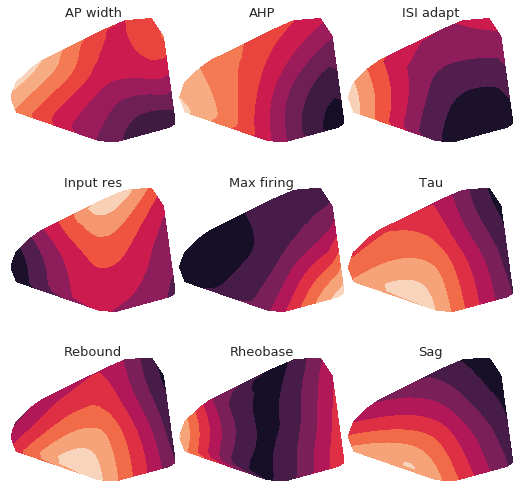

In [91]:
lasso_id=2
fig = plt.figure(figsize=(9, 9))
widths = [1,1,1]
heights = [1,1,1]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                          height_ratios=heights)

saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format(1000, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})
ind_genes = np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[1, :][-25:]
features = ['AP amp', 'AP amp adapt', 'AP amp CV', 'AP thresh', 'AP width', 'AHP', \
            'ISI adapt', 'ISI CV', 'Input res', 'Max firing', 'Tau', \
            'Rebound', r'$V_m$', 'Rheobase', 'Sag', 'UDR']
spec.update(wspace=0.025, hspace=0.13)

# Use the index of the feature that you want to see as input integer in the latent_space function
ax1 = fig.add_subplot(spec[0, 0])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        4, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax1)
ax2 = fig.add_subplot(spec[0, 1])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        5, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax2)
ax3 = fig.add_subplot(spec[0, 2])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        6, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax3)
ax4 = fig.add_subplot(spec[1, 0])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        8, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax4)
ax5 = fig.add_subplot(spec[1, 1])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        9, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax5)
ax6 = fig.add_subplot(spec[1, 2])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        10, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax6)
ax7 = fig.add_subplot(spec[2, 0])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        11, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax7)
ax8 = fig.add_subplot(spec[2, 1])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        13, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax8)
ax9 = fig.add_subplot(spec[2, 2])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        14, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax9)
#plt.tight_layout()
sns.despine(bottom=True, left=True)
plt.savefig('Bottleneck_latent_ephys.png', bbox_inches = 'tight',
    pad_inches = 0)

In [22]:
def latent_space_genes(model, X, X_column_index, geneNames, celltypes, cellTypeLabels, \
                       cellTypeColors, alpha = 0.5, axis = None):
    ''' 
    Parameters
    ----------
    model: keras deep bottleneck neural network regression model
    X: 2D numpy array, normalized transcriptomic data
    X_column_index: column index in X, correspoding to certain gene
    geneNames: list of gene names (X_column_index should correspond to correct gene in this list!)
    celltypes: 1D numpy array, same size as first dimension of X and Y, numbers denote celltype/cellclass
    celltypeLabels: dictionary with celltype numbers corresponding to celltype names
    celltypeColors: dictionary with celltype names corresponding to celltype colours
    alpha: transparancy for contours (default = 0.5)
    ax: axis to plot one (default: None)
    
    Returns
    -------
    axis: figure objects; latent space with gene activation contours
    '''
    # Create mappings from the model to get latent activations from genes and ephys predictions from genes and
    # latent activations
    encoder = Model(model.input, model.get_layer('bottleneck').output)
    latent = encoder.predict(X)                           # bottleneck representation
    ephys_prediction = saved_model.predict(X)             # class prediction
    ephys_prediction_from_bottleneck = K.function([saved_model.get_layer('bottleneck').output], [saved_model.output])
    

    
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))
        
        
    # Retrieve latent space activations
    encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
    latent = encoder.predict(X)                 # bottleneck representation

    f = SmoothBivariateSpline(latent[:, 0], latent[:, 1], X[:, X_column_index])
    ax.tricontourf(latent[:,0], latent[:,1], f.ev(latent[:, 0], latent[:,1]))
    ax.set_xlim([np.min(latent[:, 0]), np.max(latent[:, 0])])
    ax.set_ylim([np.min(latent[:, 1]), np.max(latent[:, 1])])
    #ax.scatter(latent[:,0], latent[:,1],
    #            c = X[:, X_column_index])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(geneNames[ind_genes][X_column_index], fontsize=13, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

R^2 score on all:  0.29057103395462036


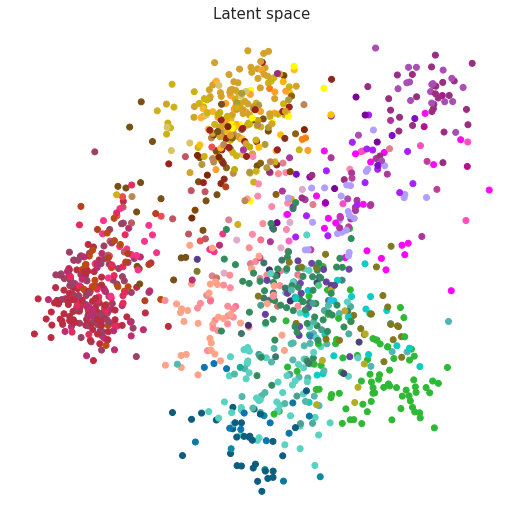

In [232]:
# Pick a NN L2 reg parameter number
lasso_id=2   # a number from 0 to 3 (corresponding to 1e-4, 1e-2, 1e-1, 1 lasso penalty respectively)



saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format(1000, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
ephys_prediction_from_bottleneck = K.function([saved_model.get_layer('bottleneck').output],
                                  [saved_model.output])
#layer_output = ephys_prediction_from_bottleneck(np.array([0, 0])[np.newaxis, :])[0]
ind_genes = np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[lasso_id, :][-25:]
latent = encoder.predict(X_no_low_qual[:, ind_genes])                 # bottleneck representation
ephys_prediction = saved_model.predict(X_no_low_qual[:, ind_genes])             # class prediction
print('R^2 score on all: ', 1-np.sum((Y_no_low_qual - \
                                      saved_model.predict(x=X_no_low_qual[:, ind_genes]))**2) / np.sum(Y_no_low_qual**2))

sns.set_style('white')
plt.figure(figsize = (9, 9))
plt.scatter(latent[:, 0], latent[:, 1],
            c = [cellTypeColors[cellTypeLabels[cell_type]] for cell_type in cellTypes_no_low_qual])
sns.despine(bottom = True, left = True)
plt.xticks([])
plt.yticks([])
plt.title('Latent space', fontsize=15)
plt.savefig('Bottleneck_latent.png', bbox_inches = 'tight',
    pad_inches = 0)

In [239]:
ind_genes

array([284,  81,  43, 171, 228,  85, 804, 801, 383, 286, 290, 906, 255,
       617, 977, 402, 502, 793, 648, 123, 699, 109, 159, 850, 890])

In [26]:
geneNames[ind_genes][::1]

array(['Flt3', 'Trp53i11', 'Ptgs2', 'Gm11549', 'Ptpru', 'Bdnf', 'Chat',
       'Fezf2', 'Atp1a3', 'Thsd7a', 'Grm7', 'Mas1', 'Cplx1', 'Vip',
       'Cbln2', 'Ndn', 'Htr3a', 'Synpr', 'Tac2', 'Lamp5', 'Coro6', 'Gad1',
       'Ndst3', 'Pvalb', 'Sst'], dtype='<U13')

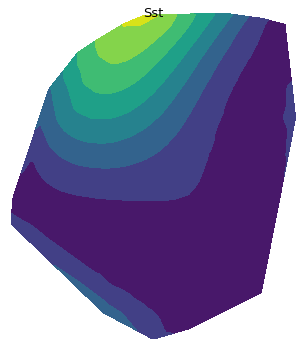

In [25]:
# Test
lasso_id=2
saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format(1000, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})
ind_genes = np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[lasso_id, :][-25:]
#for i in range(X_no_low_qual[:, ind_genes].shape[1])[0:1]:
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
        -1, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors)
sns.despine(bottom = True, left = True)
    #plt.savefig('LatentSpaceContours/LatentSpaceContoursFor_{}'.format(geneNames[i]), dpi=200)

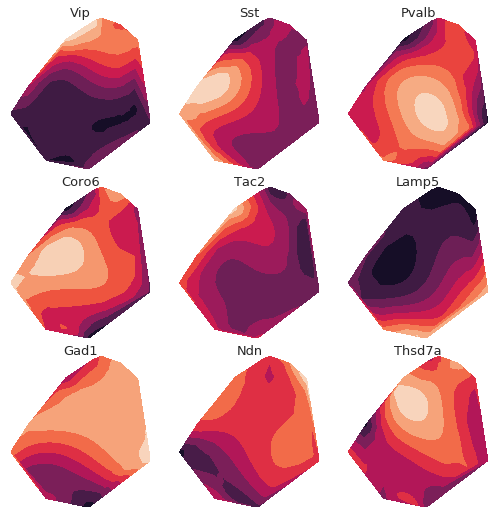

In [231]:
lasso_id=2
fig = plt.figure(figsize=(9, 9))
widths = [1,1,1]
heights = [1,1,1]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                          height_ratios=heights)

saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format(1000, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})
ind_genes = np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[1, :][-25:]
features = ['AP amp', 'AP amp adapt', 'AP amp CV', 'AP thresh', 'AP width', 'AHP', \
            'ISI adaptation', 'ISI CV', 'Input resistance', 'Max firing rate', 'Tau', \
            'Rebound', r'$V_m$', 'Rheobase', 'Sag', 'UDR']
spec.update(wspace=0.025, hspace=0.12)

# Use the index of the feature that you want to see as input integer in the latent_space function
ax1 = fig.add_subplot(spec[0, 0])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], 
        -1, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax1)
ax2 = fig.add_subplot(spec[0, 1])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes],\
        -2, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax2)
ax3 = fig.add_subplot(spec[0, 2])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
        -3, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax3)
ax4 = fig.add_subplot(spec[1, 0])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes],  \
        -4, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax4)
ax5 = fig.add_subplot(spec[1, 1])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
        -5, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax5)
ax6 = fig.add_subplot(spec[1, 2])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
        -6, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax6)
ax7 = fig.add_subplot(spec[2, 0])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
        -7, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax7)
ax8 = fig.add_subplot(spec[2, 1])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
        -8, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax8)
ax9 = fig.add_subplot(spec[2, 2])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
        -9, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax9)
#plt.tight_layout()
sns.despine(bottom=True, left=True)
plt.savefig('Bottleneck_latent_genes.png', bbox_inches = 'tight',
    pad_inches = 0)

In [43]:
# # All in one, for the paper

# lasso_id=2
# fig = plt.figure(figsize=(16, 5.2))
# widths = [3,1,1,1,1,1,1]
# heights = [1,1,1]
# spec = fig.add_gridspec(ncols=7, nrows=3, width_ratios=widths,
#                           height_ratios=heights)
# spec.update(wspace=0, hspace=0.12)

# saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
#                         format(1000, lasso_id, 0), \
#                         custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# # Retrieve activations and ephys prediction
# encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
# ephys_prediction_from_bottleneck = K.function([saved_model.get_layer('bottleneck').output],
#                                   [saved_model.output])
# #layer_output = ephys_prediction_from_bottleneck(np.array([0, 0])[np.newaxis, :])[0]
# ind_genes = np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[1, :][-25:]
# latent = encoder.predict(X_no_low_qual[:, ind_genes])                 # bottleneck representation
# ephys_prediction = saved_model.predict(X_no_low_qual[:, ind_genes])             # class prediction

# # Cell types
# ax0 = fig.add_subplot(spec[:, 0])
# ax0.scatter(latent[:, 0], latent[:, 1],
#             c = [cellTypeColors[cellTypeLabels[cell_type]] for cell_type in cellTypes_no_low_qual], s=20)
# ax0.set_aspect('equal', adjustable='box')
# ax0.set_title('sBNN latent space', fontsize=13, y=0.99)
# ax0.set_xticks([])
# ax0.set_yticks([])

# # ephys
# features = ['AP amp', 'AP amp adapt', 'AP amp CV', 'AP thresh', 'AP width', 'AHP', \
#             'ISI adapt', 'ISI CV', 'Input res', 'Max firing', 'Tau', \
#             'Rebound', r'$V_m$', 'Rheobase', 'Sag', 'UDR']
# ax1 = fig.add_subplot(spec[0, 1])
# latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
#         4, features, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax1)
# ax2 = fig.add_subplot(spec[0, 2])
# latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
#         5, features, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax2)
# ax3 = fig.add_subplot(spec[0, 3])
# latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
#         6, features, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax3)
# ax4 = fig.add_subplot(spec[1, 1])
# latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
#         8, features, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax4)
# ax5 = fig.add_subplot(spec[1, 2])
# latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
#         9, features, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax5)
# ax6 = fig.add_subplot(spec[1, 3])
# latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
#         10, features, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax6)
# ax7 = fig.add_subplot(spec[2, 1])
# latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
#         11, features, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax7)
# ax8 = fig.add_subplot(spec[2, 2])
# latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
#         13, features, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax8)
# ax9 = fig.add_subplot(spec[2, 3])
# latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
#         14, features, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax9)

# # genes
# ax10 = fig.add_subplot(spec[0, 4])
# latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], 
#         -1, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax10)
# ax11 = fig.add_subplot(spec[0, 5])
# latent_space_genes(saved_model, X_no_low_qual[:, ind_genes],\
#         -2, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax11)
# ax12 = fig.add_subplot(spec[0, 6])
# latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
#         -3, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax12)
# ax13 = fig.add_subplot(spec[1, 4])
# latent_space_genes(saved_model, X_no_low_qual[:, ind_genes],  \
#         -4, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax13)
# ax14= fig.add_subplot(spec[1, 5])
# latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
#         -5, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax14)
# ax15 = fig.add_subplot(spec[1, 6])
# latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
#         -6, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax15)
# ax16 = fig.add_subplot(spec[2, 4])
# latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
#         -7, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax16)
# ax17 = fig.add_subplot(spec[2, 5])
# latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
#         -8, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax17)
# ax18 = fig.add_subplot(spec[2, 6])
# latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
#         -9, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
#         cellTypeColors, axis=ax18)
# #plt.tight_layout()
# sns.despine(bottom=True, left=True)
# plt.text(-0.01, 1.00, 'a', transform = ax0.transAxes, fontsize=25, fontweight='bold')
# plt.text(-0.09, 1.04, 'b', transform = ax1.transAxes, fontsize=25, fontweight='bold')
# plt.text(-0.09, 1.04, 'c', transform = ax10.transAxes, fontsize=25, fontweight='bold')
# plt.savefig('Bottleneck_latent_space_all_together.png', bbox_inches = 'tight',
#     pad_inches = 0)
# #plt.savefig('Bottleneck_latent_space_all_together.pdf', bbox_inches = 'tight',
# #    pad_inches = 0)

/usr/local/lib/python3.6/dist-packages/matplotlib/gridspec.py:335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


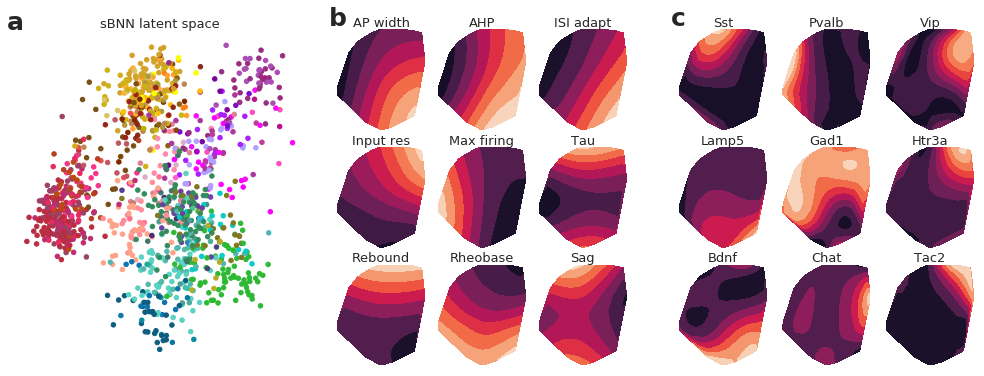

In [188]:
# All in one, for the paper
lasso_id=2
fig = plt.figure(figsize=(16, 5.2))
widths = [2.4,1,1,1]
heights = [1,1,1]
spec = fig.add_gridspec(ncols=4, nrows=3, width_ratios=widths,
                          height_ratios=heights)
spec.update(wspace=0, hspace=0.12)

saved_model = load_model('KerasSavedModels/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format(1000, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
encoder = Model(saved_model.input, saved_model.get_layer('bottleneck').output)
ephys_prediction_from_bottleneck = K.function([saved_model.get_layer('bottleneck').output],
                                  [saved_model.output])
#layer_output = ephys_prediction_from_bottleneck(np.array([0, 0])[np.newaxis, :])[0]
ind_genes = np.argsort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[lasso_id, :][-25:]
latent = encoder.predict(X_no_low_qual[:, ind_genes])                 # bottleneck representation
ephys_prediction = saved_model.predict(X_no_low_qual[:, ind_genes])             # class prediction

# Cell types
ax0 = fig.add_subplot(spec[:, 0])
ax0.scatter(latent[:, 0], latent[:, 1],
            c = [cellTypeColors[cellTypeLabels[cell_type]] for cell_type in cellTypes_no_low_qual], s=20)
ax0.set_aspect('equal', adjustable='box')
ax0.set_title('sBNN latent space', fontsize=13, y=0.99)
ax0.set_xticks([])
ax0.set_yticks([])

# ephys
features = ['AP amp', 'AP amp adapt', 'AP amp CV', 'AP thresh', 'AP width', 'AHP', \
            'ISI adapt', 'ISI CV', 'Input res', 'Max firing', 'Tau', \
            'Rebound', r'$V_m$', 'Rheobase', 'Sag', 'UDR']
ax1 = fig.add_subplot(spec[0, 1])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        4, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax1)
ax2 = fig.add_subplot(spec[0, 2])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        5, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax2)
ax3 = fig.add_subplot(spec[0, 3])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        6, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax3)
ax4 = fig.add_subplot(spec[1, 1])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        8, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax4)
ax5 = fig.add_subplot(spec[1, 2])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        9, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax5)
ax6 = fig.add_subplot(spec[1, 3])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        10, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax6)
ax7 = fig.add_subplot(spec[2, 1])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        11, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax7)
ax8 = fig.add_subplot(spec[2, 2])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        13, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax8)
ax9 = fig.add_subplot(spec[2, 3])
latent_space_ephys(saved_model, X_no_low_qual[:, ind_genes], Y_no_low_qual, \
        14, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax9)

spec.tight_layout(fig, rect=[0, 0, 0.64, 1], h_pad=0)

widths = [1,1,1]
heights = [1,1,1]
spec2 = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                          height_ratios=heights)
spec2.update(wspace=0, hspace=0.12)
# genes
# -1, -2, -12, -6, -4, -9, -20, -19, -7
ax10 = fig.add_subplot(spec2[0, 0])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], 
        -1, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax10)
ax11 = fig.add_subplot(spec2[0, 1])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes],\
        -2, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax11)
ax12 = fig.add_subplot(spec2[0, 2])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
        -12, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax12)
ax13 = fig.add_subplot(spec2[1, 0])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes],  \
        -6, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax13)
ax14= fig.add_subplot(spec2[1, 1])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
        -4, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax14)
ax15 = fig.add_subplot(spec2[1, 2])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
        -9, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax15)
ax16 = fig.add_subplot(spec2[2, 0])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
        -20, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax16)
ax17 = fig.add_subplot(spec2[2, 1])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
        -19, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax17)
ax18 = fig.add_subplot(spec2[2, 2])
latent_space_genes(saved_model, X_no_low_qual[:, ind_genes], \
        -7, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax18)
spec2.tight_layout(fig, rect=[0.535, 0, 1, 1], h_pad=0)
#plt.tight_layout()
sns.despine(bottom=True, left=True)
plt.text(-0.02, 1.00, 'a', transform = ax0.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.09, 1.04, 'b', transform = ax1.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.09, 1.04, 'c', transform = ax10.transAxes, fontsize=25, fontweight='bold')
plt.savefig('Bottleneck_latent_space_all_together.png', bbox_inches = 'tight',
    pad_inches = 0)
plt.savefig('Bottleneck_latent_space_all_together.pdf', bbox_inches = 'tight',
    pad_inches = 0)

In [62]:
# And what are the genes selected for sRRR for the different cross validated sets and the lambdau we'd have to pick?

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

t = time.time()
n = X_no_low_qual.shape[0]
X = np.copy(X_no_low_qual)
Y = np.copy(Y_no_low_qual)

X = X.astype('float64')
Y = Y.astype('float64')

vx_rank2, vy_rank2 = sparseRRR.elastic_rrr(X, Y, \
                            lambdau=lambdas[np.isclose(n_rank2, 25, atol=3)], alpha=1, rank=2, sparsity='row-wise')
print('For rank 2, ', \
      '\nThese highest genes were selected: ', \
      geneNames[np.sum(vx_rank2, axis = 1)!=0])
vx_rank16, vy_rank16 = sparseRRR.elastic_rrr(X, Y, \
                            lambdau=lambdas[np.isclose(n_rank16, 25, atol=3)], alpha=1, rank=16, sparsity='row-wise')

print('For rank 16, ', \
      '\nThese highest genes were selected: ', \
      geneNames[np.sum(vx_rank16, axis = 1)!=0])

For rank 2,  
These highest genes were selected:  ['Bdnf' 'Gad1' 'Lamp5' 'Plch2' 'Gabrd' 'Cacna2d1' 'Elfn1' 'Slc6a1' 'Tac1'
 'Npas1' 'Arpp21' 'Htr3a' 'Mybpc1' 'Coro6' 'Nrn1' 'Synpr' 'Ptk2b' 'Kcnv1'
 'Pvalb' 'Sst' 'Kcnip2']
For rank 16,  
These highest genes were selected:  ['Erbb4' 'Bdnf' 'Gad1' 'Lamp5' 'Bcan' 'Plch2' 'Gabrd' 'Cacna2d1' 'Elfn1'
 'Slc6a1' 'Tac1' 'Arpp21' 'Htr3a' 'Mybpc1' 'Vip' 'Coro6' 'Nrn1' 'Synpr'
 'Ptk2b' 'Pvalb' 'Sst' 'Kcnip2']


In [148]:
lambdas[np.isclose(n_rank2, 25, atol=3)]

array([0.4])

In [185]:
# Let us make sure to select exactly 25 genes now.
X = np.copy(X_no_low_qual)
Y = np.copy(Y_no_low_qual)
X = X.astype('float64')
Y = Y.astype('float64')
vx_rank2, vy_rank2 = sparseRRR.elastic_rrr(X, Y, \
                            lambdau=0.34, alpha=1, rank=2, sparsity='row-wise')
print('For rank 2, ', \
      '\nThese highest genes were selected: ', \
      geneNames[np.sum(vx_rank2, axis = 1)!=0])
print('# of genes: ', np.sum(np.sum(vx_rank2, axis = 1)!=0))
# We want to select Sst, Pvalb, Vip, Lamp5, Gad1, Htr3a, Bdnf, Chat, Tac2, are they here in this run?
# 22, 21, 14, 2, 1, 13, 0, 5, 9

For rank 2,  
These highest genes were selected:  ['Bdnf' 'Gad1' 'Lamp5' 'Plch2' 'Gabrd' 'Cacna2d1' 'Elfn1' 'Slc6a1' 'Nxph1'
 'Tac1' 'Npas1' 'Ndn' 'Arpp21' 'Htr3a' 'Mybpc1' 'Tac2' 'Coro6' 'Nrn1'
 'Synpr' 'Ptk2b' 'Kcnv1' 'Pvalb' 'Sst' 'Galnt14' 'Kcnip2']
# of genes:  25


In [219]:
def latent_space_ephys_sRRR(X, vx, vy, Y_column_index, features, celltypes, cellTypeLabels, \
                       cellTypeColors, alpha = 1, axis = None):

    '''
    Parameters
    ----------
    model: keras deep bottleneck neural network regression model
    X: 2D numpy array, normalized transcriptomic data
    vx: matrix to (linearly) project to botteneck
    vy: matrix to (linearly) project from bottleneck to ephys space
    Y_column_index: column index in Y, correspoding to certain feature
    features: list of all ephys features (Y_column_index should correspond to correct feature in this list!)
    celltypes: 1D numpy array, same size as first dimension of X and Y, numbers denote celltype/cellclass
    celltypeLabels: dictionary with celltype numbers corresponding to celltype names
    celltypeColors: dictionary with celltype names corresponding to celltype colours
    alpha: transparancy for contours (default = 0.5)
    axis: axis to plot one (default: None)
    
    Returns
    -------
    ax: figure object, latent space with ephys activation contours
    '''
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))
    
    ax.tricontourf((X@vx)[:, 1], (X@vx)[:, 0], (X@vx@vy.T)[:, Y_column_index])
    #ax.scatter((X@vx)[:, 0], (X@vx)[:, 1], c = (X@vx@vy.T)[:, Y_column_index])
    ax.set_xlim([np.min((X@vx)[:, 1]), np.max((X@vx)[:, 1])])
    ax.set_ylim([np.min((X@vx)[:, 0]), np.max((X@vx)[:, 0])])
    #ax.set_xlim([-2, 5])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(features[Y_column_index], fontsize=13, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

In [252]:
def latent_space_genes_sRRR(X, vx, index, geneNames, celltypes, cellTypeLabels, \
                       cellTypeColors, alpha = 0.5, axis = None):
    ''' 
    Parameters
    ----------
    model: keras deep bottleneck neural network regression model
    X: 2D numpy array, normalized transcriptomic data
    vx: matrix to (linearly) project to botteneck
    vy: matrix to (linearly) project from bottleneck to ephys space
    index: index in the 25 genes selected for the gene that you'd like to show
    geneNames: list of gene names (X_column_index should correspond to correct gene in this list!)
    celltypes: 1D numpy array, same size as first dimension of X and Y, numbers denote celltype/cellclass
    celltypeLabels: dictionary with celltype numbers corresponding to celltype names
    celltypeColors: dictionary with celltype names corresponding to celltype colours
    alpha: transparancy for contours (default = 0.5)
    ax: axis to plot one (default: None)
    
    Returns
    -------
    axis: figure objects; latent space with gene activation contours
    '''
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))

    f = SmoothBivariateSpline((X@vx)[:, 1], (X@vx)[:, 0], X[:, np.sum(vx, axis = 1)!=0][:, index])
    ax.tricontourf((X@vx)[:,1], (X@vx)[:,0], f.ev((X@vx)[:, 1], (X@vx)[:,0]))
    ax.set_xlim([np.min((X@vx)[:, 1]), np.max((X@vx)[:, 1])])
    ax.set_ylim([np.min((X@vx)[:, 0]), np.max((X@vx)[:, 0])])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(geneNames[np.sum(vx, axis = 1)!=0][index], fontsize=13, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

/usr/local/lib/python3.6/dist-packages/matplotlib/gridspec.py:335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


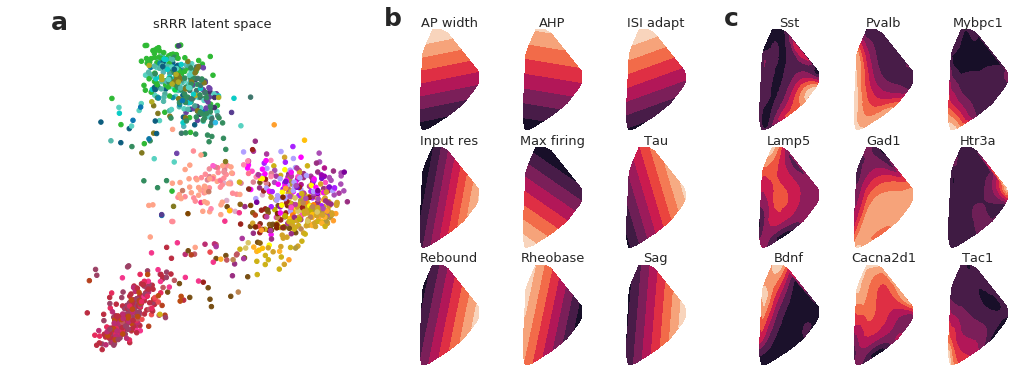

In [254]:
# All in one, for the paper
lasso_id=2
fig = plt.figure(figsize=(16, 5.2))
widths = [3,1,1,1]
heights = [1,1,1]
spec = fig.add_gridspec(ncols=4, nrows=3, width_ratios=widths,
                          height_ratios=heights)
spec.update(wspace=0, hspace=0.12)

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

    
vx_rank2, vy_rank2 = sparseRRR.elastic_rrr(X, Y, \
                            lambdau=0.34, alpha=1, rank=2, sparsity='row-wise')    
    
# Cell types
ax0 = fig.add_subplot(spec[:, 0])
ax0.scatter((X@vx_rank2)[:, 1], (X@vx_rank2)[:, 0],
            c = [cellTypeColors[cellTypeLabels[cell_type]] for cell_type in cellTypes_no_low_qual], s=20)
#ax0.set_aspect('equal', adjustable='box')
ax0.set_title('sRRR latent space', fontsize=13, y=0.99)
ax0.set_xlim([-2.5, 2.5])
ax0.set_xticks([])
ax0.set_yticks([])

# ephys
features = ['AP amp', 'AP amp adapt', 'AP amp CV', 'AP thresh', 'AP width', 'AHP', \
            'ISI adapt', 'ISI CV', 'Input res', 'Max firing', 'Tau', \
            'Rebound', r'$V_m$', 'Rheobase', 'Sag', 'UDR']
ax1 = fig.add_subplot(spec[0, 1])
latent_space_ephys_sRRR(X_no_low_qual, vx_rank2, vy_rank2, \
        4, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax1)
ax2 = fig.add_subplot(spec[0, 2])
latent_space_ephys_sRRR(X_no_low_qual, vx_rank2, vy_rank2, \
        5, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax2)
ax3 = fig.add_subplot(spec[0, 3])
latent_space_ephys_sRRR(X_no_low_qual, vx_rank2, vy_rank2, \
        6, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax3)
ax4 = fig.add_subplot(spec[1, 1])
latent_space_ephys_sRRR(X_no_low_qual, vx_rank2, vy_rank2, \
        8, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax4)
ax5 = fig.add_subplot(spec[1, 2])
latent_space_ephys_sRRR(X_no_low_qual, vx_rank2, vy_rank2, \
        9, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax5)
ax6 = fig.add_subplot(spec[1, 3])
latent_space_ephys_sRRR(X_no_low_qual, vx_rank2, vy_rank2, \
        10, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax6)
ax7 = fig.add_subplot(spec[2, 1])
latent_space_ephys_sRRR(X_no_low_qual, vx_rank2, vy_rank2, \
        11, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax7)
ax8 = fig.add_subplot(spec[2, 2])
latent_space_ephys_sRRR(X_no_low_qual, vx_rank2, vy_rank2, \
        13, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax8)
ax9 = fig.add_subplot(spec[2, 3])
latent_space_ephys_sRRR(X_no_low_qual, vx_rank2, vy_rank2, \
        14, features, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax9)

spec.tight_layout(fig, rect=[0, 0, 0.64, 1], h_pad=0)

widths = [1,1,1]
heights = [1,1,1]
spec2 = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                          height_ratios=heights)
spec2.update(wspace=0, hspace=0.12)
# genes
# 22, 21, 14, 2, 1, 13, 0, 5, 9
ax10 = fig.add_subplot(spec2[0, 0])
latent_space_genes_sRRR(X_no_low_qual, vx_rank2, \
        22, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax10)
ax11 = fig.add_subplot(spec2[0, 1])
latent_space_genes_sRRR(X_no_low_qual, vx_rank2, \
        21, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax11)
ax12 = fig.add_subplot(spec2[0, 2])
latent_space_genes_sRRR(X_no_low_qual,  vx_rank2, \
        14, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax12)
ax13 = fig.add_subplot(spec2[1, 0])
latent_space_genes_sRRR(X_no_low_qual,   vx_rank2, \
        2, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax13)
ax14= fig.add_subplot(spec2[1, 1])
latent_space_genes_sRRR(X_no_low_qual, vx_rank2, \
        1, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax14)
ax15 = fig.add_subplot(spec2[1, 2])
latent_space_genes_sRRR(X_no_low_qual, vx_rank2, \
        13, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax15)
ax16 = fig.add_subplot(spec2[2, 0])
latent_space_genes_sRRR(X_no_low_qual, vx_rank2, \
        0, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax16)
ax17 = fig.add_subplot(spec2[2, 1])
latent_space_genes_sRRR(X_no_low_qual, vx_rank2, \
        5, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax17)
ax18 = fig.add_subplot(spec2[2, 2])
latent_space_genes_sRRR(X_no_low_qual, vx_rank2, \
        9, geneNames, cellTypes_no_low_qual, cellTypeLabels, \
        cellTypeColors, axis=ax18)
spec2.tight_layout(fig, rect=[0.54, 0, 1, 1], h_pad=0)
#plt.tight_layout()
sns.despine(bottom=True, left=True)
plt.text(0.1, 1.00, 'a', transform = ax0.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.6, 1.04, 'b', transform = ax1.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.6, 1.04, 'c', transform = ax10.transAxes, fontsize=25, fontweight='bold')
plt.savefig('Bottleneck_latent_space_all_together_sRRR.png', bbox_inches = 'tight',
    pad_inches = 0)
plt.savefig('Bottleneck_latent_space_all_together_sRRR.pdf', bbox_inches = 'tight',
    pad_inches = 0)